#### What is DeepAR ? Why are we using this in Walmart Store Sales forecasting?
* As we have visulaized our dataset we see that each store and department represents a different time series.
* In order to train our model to predict future sales per store and department , we need multiple time series models per store and department as there are close to 45 stores and 80 departments so totally 3600 models has to be trained. 
* DeepAR is a supervised learning algorthim for forecasting multiple Time series by a single model which uses Recurent Neural Network and outputs us with probabilistic and point in time forecast.
* It's useful as it reduces computation time by its One-Fits all algorithm and fits separate time series for each combination

In [5]:
import os, sys 
# #to be able to interact with Google Drive's operating system
# from google.colab import drive 
# #drive is a module that allows us use Python to interact with google drive
# drive.mount('/content/gdrive') 
#mounting google drive allows us to work with its contents
#nb_path = '/content/notebooks/'
#os.symlink('/content/gdrive/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0, nb_path)  # or append(nb_path)
# #The last three lines are what changes the path of the file.

In [6]:
#! pip uninstall mxnet~=1.7 gluonts

In [7]:
# import sys
# sys.path.append('/content/gdrive/My Drive/Colab Notebooks/')

In [8]:
### importing necessary libraries
import warnings
warnings.filterwarnings("ignore")
from tqdm.autonotebook import tqdm
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
import numpy as np
import os 
from numpy.random import random
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
import sys 
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['axes.grid'] = False

In [9]:
# !cp -r '/content/gdrive/MyDrive/trte_fetaured.csv' '/content/'

In [11]:
### let's prepare the datasets
df = pd.read_csv('trte_featured.csv',index_col=[2],parse_dates=[2])

In [12]:
df.loc[(df['Weekly_Sales'] < 0),'Weekly_sales'] = 0 

In [13]:
train_data = df[df['set_type'] == 'Train'].drop(['set_type'],axis=1)
test_data = df[df['set_type'] == 'Test'].drop(['set_type'],axis=1)

In [20]:
train_only_timedata =  train_data[['Store','Dept','Weekly_Sales']]
### create a column for each store and department combination to store sales values 
train_only_timedata['Store_Dept'] = train_only_timedata.apply(lambda x : '_'.join(['S'+str(int(x['Store'])),'D'+str(int(x['Dept']))]),axis=1)
train_only_timedata = train_only_timedata.drop(['Store','Dept'],axis=1)
## for test

test_only_timedata =  test_data[['Store','Dept','Weekly_Sales']]
# ### create a column for each store and department combination to store sales values 
test_only_timedata['Store_Dept'] = test_only_timedata.apply(lambda x : '_'.join(['S'+str(int(x['Store'])),'D'+str(int(x['Dept']))]),axis=1)
test_only_timedata = test_only_timedata.drop(['Store','Dept'],axis=1)

Now we are creating dynamic features df for training!!! we do not include any time related features here as DeepAR itself develops time based features likee week,month,year, and lags (based on seasonality of series) as part of its model development and enchancement!! so let's remove them

In [48]:
### create dynamic features for train
dynamic_cols = ['Store','Dept','IsHoliday', 'Temperature','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown5', 'CPI',
       'Unemployment', 'Type', 'Size','major_holiday', 'rolling_mean', 'expanding_mean', 'EWM_0.1', 'EWM_0.4',
       'EWM_0.5', 'EWM_0.7', 'holt_avg']
train_dynamic_feat = train_data[dynamic_cols]
### create a column for each store and department combination to store sales values 
train_dynamic_feat['Store_Dept'] = train_dynamic_feat.apply(lambda x : '_'.join(['S'+str(int(x['Store'])),'D'+str(int(x['Dept']))]),axis=1)
train_dynamic_feat = train_dynamic_feat.drop(['Store','Dept'],axis=1)
train_dynamic_feat =  train_dynamic_feat.fillna(-1)
### same for test
test_dynamic_feat = test_data[dynamic_cols]
### create a column for each store and department combination to store sales values 

test_dynamic_feat['Store_Dept'] = test_dynamic_feat.apply(lambda x : '_'.join(['S'+str(int(x['Store'])),'D'+str(int(x['Dept']))]),axis=1)
test_dynamic_feat = test_dynamic_feat.drop(['Store','Dept'],axis=1)
test_dynamic_feat =  test_dynamic_feat.fillna(-1)



In [22]:
train_dynamic_feat.head(2)

,IsHoliday,Temperature,MarkDown1,MarkDown2,MarkDown3,MarkDown5,CPI,Unemployment,Type,Size,major_holiday,rolling_mean,expanding_mean,EWM_0.1,EWM_0.4,EWM_0.5,EWM_0.7,holt_avg,Store_Dept
Date,,,,,,,,,,,,,,,,,,,
2010-02-05,0,42.31,8536.592778,3346.401918,1670.797978,4428.307667,211.096358,8.106,1,151315,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,24924.500,S1_D1
2010-02-12,1,38.51,8536.592778,3346.401918,1670.797978,4428.307667,211.242170,8.106,1,151315,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44921.068,S1_D1


In [23]:
test_dynamic_feat.head(2)

,IsHoliday,Temperature,MarkDown1,MarkDown2,MarkDown3,MarkDown5,CPI,Unemployment,Type,Size,major_holiday,rolling_mean,expanding_mean,EWM_0.1,EWM_0.4,EWM_0.5,EWM_0.7,holt_avg,Store_Dept
Date,,,,,,,,,,,,,,,,,,,
2012-11-02,0,55.32,6766.44,5147.70,50.82,2737.42,223.462779,6.573,1,151315,0.0,31605.920,22442.783,22196.071,31349.889,33411.648,36621.528,34749.232,S1_D1
2012-11-09,0,61.24,11421.32,3370.89,40.28,6154.16,223.481307,6.573,1,151315,0.0,30051.833,22402.425,21845.418,26285.750,26050.594,24069.136,16410.286,S1_D1


In [24]:
train_only_timedata.head(2)

,Weekly_Sales,Store_Dept
Date,,
2010-02-05,24924.50,S1_D1
2010-02-12,46039.49,S1_D1


In [25]:
test_only_timedata.head(2)

,Weekly_Sales,Store_Dept
Date,,
2012-11-02,NaN,S1_D1
2012-11-09,NaN,S1_D1


In [26]:
def impute_missing_values(input_df,output_df):
    last_train_date = input_df.index[-1]
    start_train_date = input_df.index[0]
    test_dates = pd.date_range(start = last_train_date,periods=39 + 1,freq='W-Fri' )[1:]
    for td in test_dates:
        sum_ = np.array(0)
        cnt = 0
        for i in range(1,3):
            past_train_dates = np.array(input_df[(input_df.index == str(td - pd.Timedelta(days=364*i)))]['Weekly_Sales'])
            if len(past_train_dates) != 0: 
                sum_ = sum_ + past_train_dates 
                cnt+=1        
        mean_ = np.round(sum_ /cnt,3)
        output_df.loc[(output_df.index == str(td)),['Weekly_Sales']]  = mean_
    return output_df  

In [27]:
test_only_timedata_imputed =  impute_missing_values(train_only_timedata.copy(),test_only_timedata.copy())

In [28]:
test_only_timedata_imputed.head(10)

,Weekly_Sales,Store_Dept
Date,,
2012-11-02,37062.470,S1_D1
2012-11-09,19119.465,S1_D1
2012-11-16,19301.750,S1_D1
2012-11-23,19865.770,S1_D1
2012-11-30,23905.525,S1_D1
2012-12-07,32401.785,S1_D1
2012-12-14,45342.945,S1_D1
2012-12-21,51359.990,S1_D1
2012-12-28,21237.730,S1_D1


In [29]:
### store unique store and department ids
store_dept_cols = [i for i in train_only_timedata.Store_Dept.unique()]
train_only_td_prepared = pd.DataFrame(index=train_only_timedata.index.unique())

## for each store and department id create column and store the weekly sales as column values
for i in store_dept_cols:
    train_only_td_prepared[i] =  np.array(train_only_timedata.loc[(train_only_timedata.Store_Dept == i)]['Weekly_Sales'])

In [30]:
### do same for test imputed 

### store unique store and department ids
store_dept_cols = [i for i in test_only_timedata_imputed.Store_Dept.unique()]
test_only_td_prepared = pd.DataFrame(index=test_only_timedata_imputed.index.unique())

## for each store and department id create column and store the weekly sales as column values
for i in store_dept_cols:
    test_only_td_prepared[i] =  np.array(test_only_timedata_imputed.loc[(test_only_timedata_imputed.Store_Dept == i)]['Weekly_Sales'])

In [31]:
if ('Store' or 'Dept') in dynamic_cols:
   dynamic_cols.remove('Store')
   dynamic_cols.remove('Dept')

#### lets prepare our dynamic features
store_dept_cols = [i for i in train_dynamic_feat.Store_Dept.unique()]

### our 18 dynamic feaures also time varient so our overall dynamic array will be 3d.Per store and department we have 18 features which varies with time 
train_dynamic_prepared = [] 
for i in store_dept_cols:
     train_dynamic_prepared.append(np.array(train_dynamic_feat.loc[train_dynamic_feat.Store_Dept == i ].drop(columns=['Store_Dept'],axis=1).reset_index(drop=True)).T)

In [32]:
#### lest prepare our test set with dynamic features
test_dynamic_prepared = [] 
for i in store_dept_cols:
     test_dynamic_prepared.append(np.array(test_dynamic_feat.loc[test_dynamic_feat.Store_Dept == i ].drop(columns=['Store_Dept'],axis=1).reset_index(drop=True)).T)

In [33]:
train_dynamic_prepared =  np.array(train_dynamic_prepared)
print('Shape of our prepared Deep AR dynamic features training data',train_dynamic_prepared.shape)

Shape of our prepared Deep AR dynamic features training data (3323, 18, 143)


In [34]:
test_dynamic_prepared =  np.array(test_dynamic_prepared)
print('Shape of our prepared Deep AR dynamic features testing data',test_dynamic_prepared.shape)

Shape of our prepared Deep AR dynamic features testing data (3323, 18, 39)


In [35]:
print('Shape of our prepared Deep AR training data',train_only_td_prepared.shape)

Shape of our prepared Deep AR training data (143, 3323)


In [36]:
print('Shape of our prepared Deep AR test data',test_only_td_prepared.shape)

Shape of our prepared Deep AR test data (39, 3323)


In [37]:
### lets' check our data
test_only_td_prepared.head(5)

,S1_D1,S1_D2,S1_D3,S1_D4,S1_D5,S1_D6,S1_D7,S1_D8,S1_D9,S1_D10,...,S45_D87,S45_D90,S45_D91,S45_D92,S45_D93,S45_D94,S45_D95,S45_D96,S45_D97,S45_D98
Date,,,,,,,,,,,,,,,,,,,,,
2012-11-02,37062.470,46847.525,9507.210,38667.695,27929.940,5630.010,21659.770,36571.030,49735.040,31566.245,...,5577.390,24822.290,16815.750,53112.920,1983.470,3731.805,48883.560,0.0,6360.525,394.830
2012-11-09,19119.465,44065.480,9553.205,35917.275,27350.770,3887.980,23481.025,34765.580,37418.810,29317.505,...,6378.445,24679.475,17151.925,54584.925,2161.630,4166.105,48782.735,0.0,6160.350,478.340
2012-11-16,19301.750,42720.515,9653.235,37367.595,26027.930,3074.315,23133.440,34464.405,28247.070,27040.055,...,5740.715,24868.035,16473.655,52665.920,2353.450,3809.340,45703.465,0.0,5932.810,362.920
2012-11-23,19865.770,44970.785,10012.185,46382.705,74749.505,19396.760,71893.200,33671.690,43366.480,30984.100,...,7689.620,26083.480,13387.965,51980.560,3096.345,4552.070,45854.210,0.0,5266.965,564.975
2012-11-30,23905.525,45166.580,10501.695,37800.090,34522.145,5798.795,40262.580,36054.830,22510.965,29282.300,...,6112.450,23872.100,15338.530,46862.745,1698.260,3281.865,45824.225,0.0,5988.745,443.945


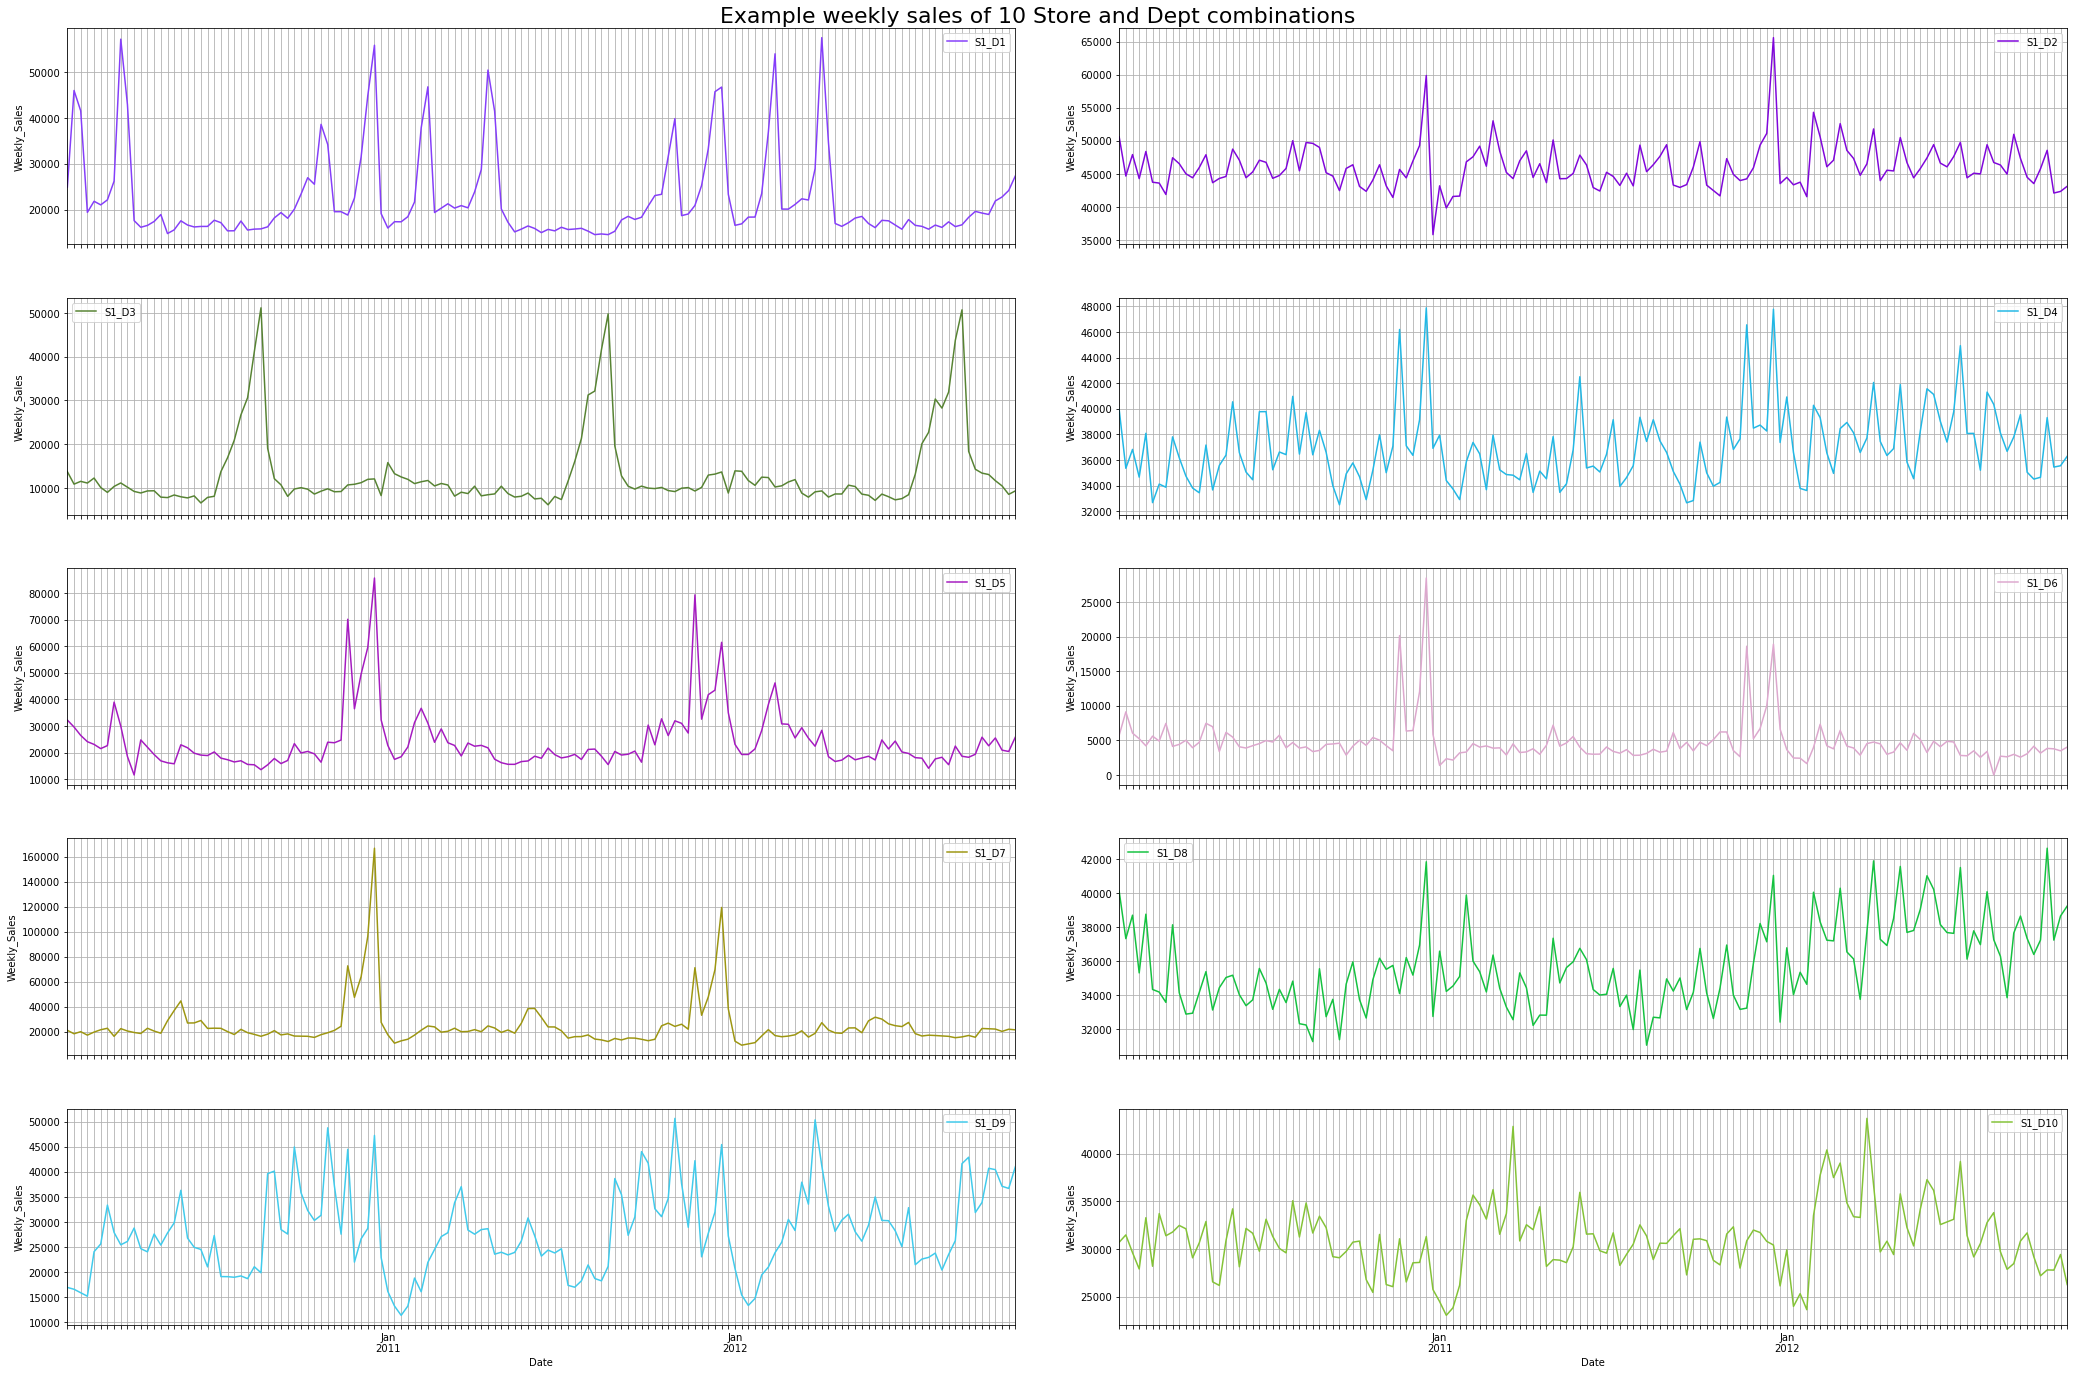

In [38]:
### let's visualize our data :
fig,axes = plt.subplots(5,2,figsize=(30,20),sharex=True)
axx = axes.ravel()
fig.suptitle('Example weekly sales of 10 Store and Dept combinations',size=22)
for i in range(0,10):
  train_only_td_prepared[[train_only_td_prepared.columns[i]]].plot(ax=axx[i],color=(random(),random(),random()))
  axx[i].set_xlabel('Date')
  axx[i].grid()
  axx[i].set_xticks(train_only_td_prepared.index)
  axx[i].set_ylabel('Weekly_Sales')
fig.tight_layout(pad=5)   

As we can see from the graph , each store's department has different seasonality pattern which keeps repeating over the years.


In [39]:
### transposing the data such that SnDn appears as rows and columns are weekly sales.dates are reindexed as numbers 0-143
train_only_td_prepared = train_only_td_prepared.reset_index(drop=True).T.reset_index()  

In [40]:
### do same for test
### transposing the data such that SnDn appears as rows and columns are weekly sales.dates are reindexed as numbers 0-143
test_only_td_prepared = test_only_td_prepared.reset_index(drop=True).T.reset_index()  
## now we will code the index (SnDn) which uniquely identifies the store and department
test_only_td_codes = test_only_td_prepared['index'].astype('category').cat.codes.values
test_only_td_codes.shape

(3323,)

In [41]:
ts_codes =  train_only_td_prepared['index'].astype('category').cat.codes.values

In [42]:
### lets implememt our DeepAR model
freq = 'W'
start_train = pd.Timestamp('2010-02-05',freq=freq)
start_test = pd.Timestamp('2012-04-13',freq=freq)

In [43]:
prediction_length = 29

In [44]:
train_df = train_only_td_prepared.iloc[:,1:115].values
test_df = train_only_td_prepared.iloc[:,115:].values

In [45]:
train_dynamic_df = train_dynamic_prepared[:,:,:114]
test_dynamic_df = test_dynamic_prepared[:,:,114:]

In [46]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_length
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [47]:
## define estimator

estimator = DeepAREstimator(freq='W',
                            context_length=50,## how much past we need to go
                            prediction_length=29,## future steps
                            use_feat_static_cat=True, ## for identifying each category of time series
                            num_layers=2,
                            cardinality = [1],
                            #use_feat_dynamic_real = True,
                            scaling=True,
                            cell_type='lstm',
                            num_cells=80,
                            trainer=Trainer(learning_rate=0.01,
                                            learning_rate_decay_factor = 0.0005,
                                            patience=2,
                                            epochs=40,
                                            num_batches_per_epoch=40))


In [49]:
train_only_td_prepared[0:7]

,index,0,1,2,3,4,5,6,7,8,...,133,134,135,136,137,138,139,140,141,142
0,S1_D1,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,57258.43,...,16286.40,16680.24,18322.37,19616.22,19251.50,18947.81,21904.47,22764.01,24185.27,27390.81
1,S1_D2,50605.27,44682.74,47928.89,44292.87,48397.98,43751.94,43615.49,41892.55,47450.50,...,44972.52,50995.50,47344.50,44493.61,43541.07,45784.76,48577.08,42112.67,42354.72,43134.88
2,S1_D3,13740.12,10887.84,11523.47,11135.17,12275.58,10123.45,9001.37,10366.85,11157.08,...,43712.78,50701.30,18368.51,14288.22,13403.63,13085.95,11676.98,10487.17,8548.87,9350.90
3,S1_D4,39954.04,35351.21,36826.95,34660.16,38086.19,32668.67,34118.11,33872.07,37809.49,...,36674.67,37802.97,39549.27,35044.06,34507.34,34647.33,39311.93,35446.18,35549.19,36292.60
4,S1_D5,32229.38,29620.81,26468.27,24101.89,23082.14,21498.92,22632.57,38971.89,29967.92,...,22446.23,18615.76,18236.15,19369.52,25798.78,22560.39,25508.81,20920.03,20413.83,25846.94
5,S1_D6,5749.03,9135.00,6060.26,5244.56,4221.25,5619.00,4906.05,7468.33,4132.61,...,2626.50,2987.07,2576.64,3073.31,4159.51,3168.68,3843.29,3788.59,3496.69,4032.50
6,S1_D7,21084.08,18310.31,19985.20,17224.22,19659.70,21529.14,22711.59,16254.21,22427.62,...,15159.94,15802.09,16941.42,15525.82,22542.44,22343.24,22071.39,20212.71,21937.45,21449.85


In [50]:
train_ds = ListDataset([
                        {
                         FieldName.TARGET : target,
                         FieldName.START :  start_train,
                         FieldName.FEAT_STATIC_CAT : fsc,
                         FieldName.FEAT_DYNAMIC_REAL : dyc                    
                        }
                        for (target,fsc,dyc) in zip(train_df[40:48],ts_codes[40:48].reshape(-1,1),train_dynamic_df[40:48])
                       ],freq=freq)
test_ds = ListDataset([
                        {
                         FieldName.TARGET : target,
                         FieldName.START :  start_test,
                         FieldName.FEAT_STATIC_CAT : fsc,   
                         FieldName.FEAT_DYNAMIC_REAL : dyc                  
                        }
                        for (target,fsc,dyc) in zip(test_df[40:48],ts_codes[40:48].reshape(-1,1),test_dynamic_df[40:48])
                       ],freq=freq)

In [51]:

## let's see how data looks
next(iter(train_ds))

{'target': array([4674.75, 4463.33, 4401.78, 3864.43, 4465.33, 4914.41, 3680.66,
        4014.61, 4216.19, 3689.94, 4159.49, 4486.95, 4414.76, 5201.2 ,
        4559.25, 4564.94, 3995.99, 4407.29, 4740.63, 4158.61, 4452.56,
        4137.45, 3893.2 , 3454.13, 3980.92, 3839.45, 5151.43, 4062.09,
        3980.15, 4260.92, 5213.53, 5082.72, 5128.87, 6279.62, 4484.02,
        5755.38, 5322.96, 5830.18, 6183.91, 4669.76, 4641.38, 4338.65,
        8324.33, 5773.13, 6310.08, 7296.46, 7081.19, 2940.67, 3825.19,
        3206.15, 3891.96, 4587.65, 4552.77, 4128.84, 4505.01, 3964.39,
        4539.32, 3902.25, 3327.64, 3688.78, 3978.69, 4593.66, 4044.26,
        4602.13, 4256.67, 5698.17, 4877.4 , 4432.13, 4210.25, 3398.8 ,
        3994.08, 3599.74, 3952.92, 4061.53, 3590.9 , 3632.48, 3385.24,
        3939.12, 4242.68, 4532.06, 4211.91, 4785.79, 5085.98, 5234.34,
        4747.74, 5426.25, 5740.86, 6259.82, 6644.37, 5357.89, 7105.29,
        5626.16, 5859.12, 5545.99, 7463.46, 6846.36, 9623.65, 9212.

In [52]:
### prediction
predictor =  estimator.train(training_data = train_ds)

100%|██████████| 40/40 [00:11<00:00,  3.59it/s, epoch=19/40, avg_epoch_loss=4.95]


Let's save our input test and validation data to csv file


In [ ]:
# train_data =  train_only_td_prepared.iloc[:,1:115]
# validation_data =  train_only_td_prepared.iloc[:,115:]
# train_data.to_csv('train_data.csv')
# validation_data.to_csv('validation_data.csv')

#### hyper parameter tuning train and cv !!

In [8]:
train_df = pd.read_csv('train_data.csv').drop(columns = ['Unnamed: 0'],axis=1)
test_df = pd.read_csv('validation_data.csv').drop(columns = ['Unnamed: 0'],axis=1)

In [9]:
## define hyper parameteres
#hyper_parameters = {
context_length = [29,36,50]
num_layers = [2,3]
num_cells = [64,80,103]
learning_rate = [0.01,0.001]
patience = [2,3]
epochs = [10,30,40]
num_batches_per_epoch = [40]
 #                   }


In [10]:
import itertools
parameter_combination = list(itertools.product(context_length,num_layers,num_cells,learning_rate,patience,epochs,num_batches_per_epoch))

In [59]:
train_ds = ListDataset([
                        {
                         FieldName.TARGET : target,
                         FieldName.START :  start_train,
                         FieldName.FEAT_STATIC_CAT : fsc                   
                        }
                        for (target,fsc) in zip(train_df,ts_codes.reshape(-1,1))
                       ],freq=freq)
test_ds = ListDataset([
                        {
                         FieldName.TARGET : target,
                         FieldName.START :  start_test,
                         FieldName.FEAT_STATIC_CAT : fsc                  
                        }
                        for (target,fsc) in zip(test_df,ts_codes.reshape(-1,1))
                       ],freq=freq)

Running evaluation: 100%|██████████| 3323/3323 [00:21<00:00, 154.76it/s]


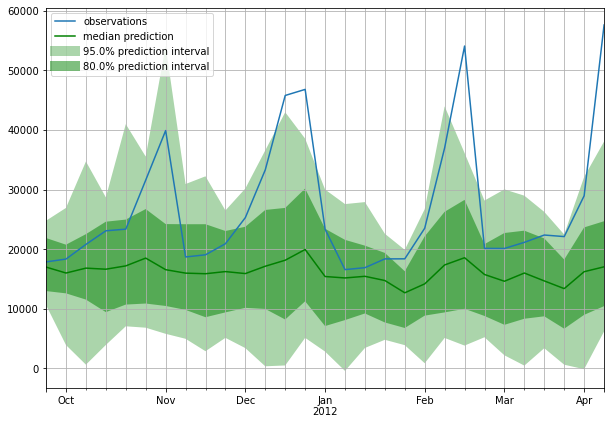

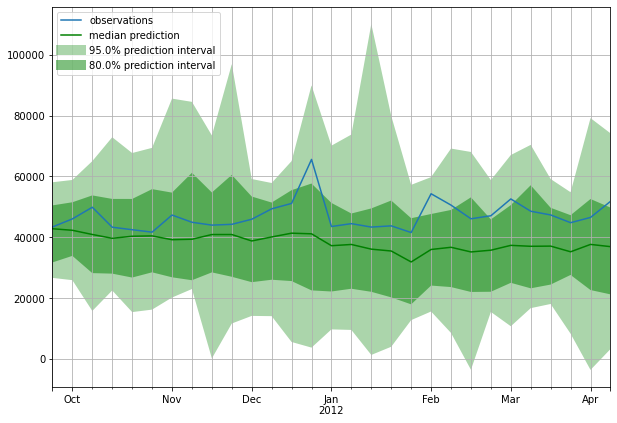

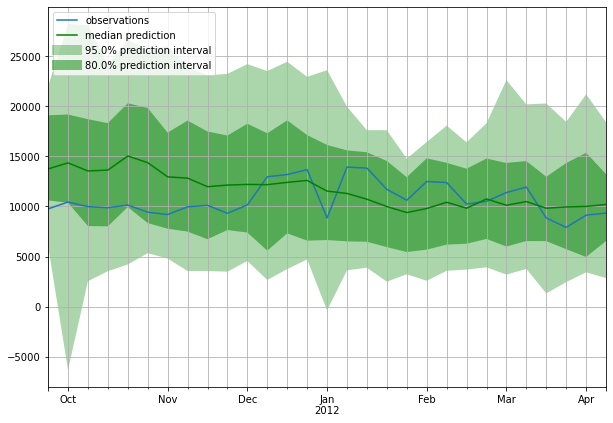

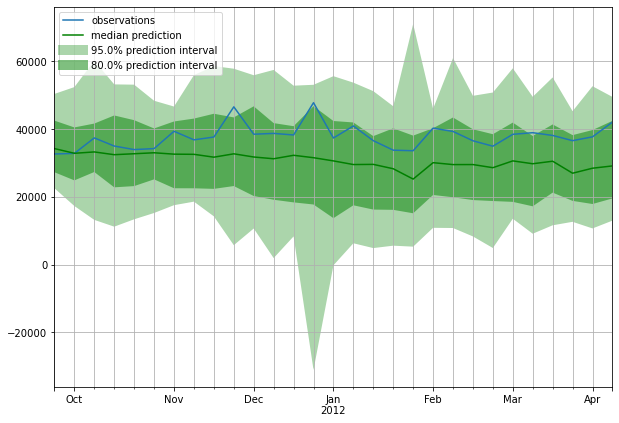

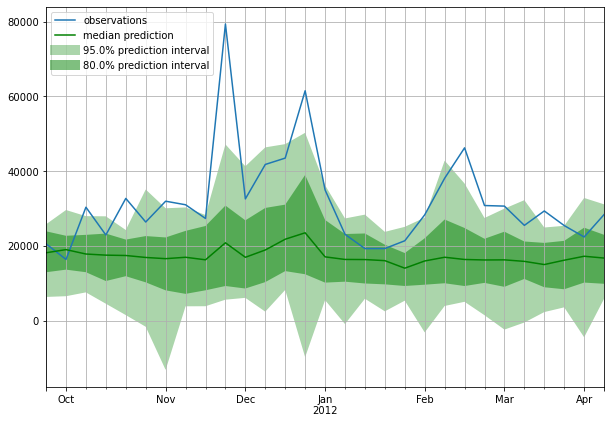

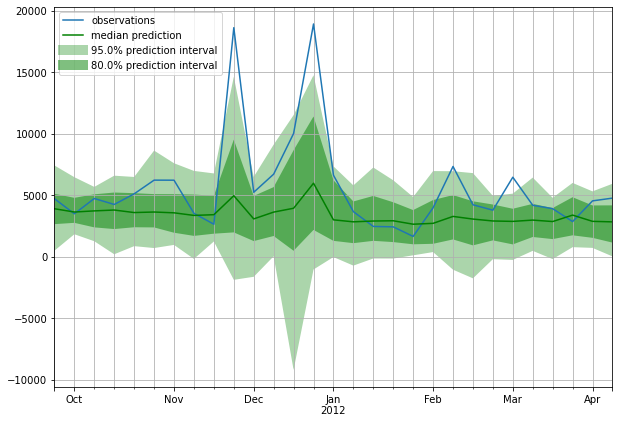

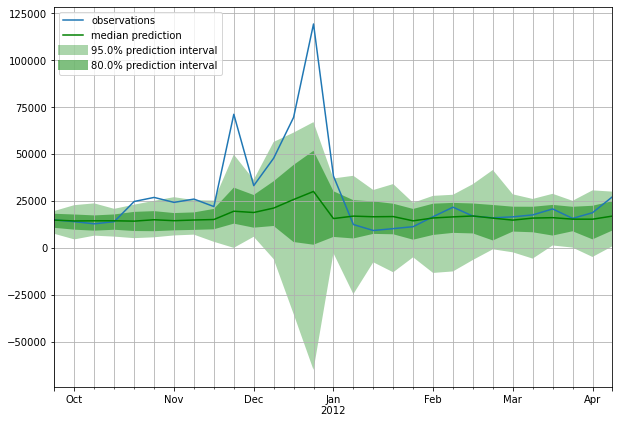

In [70]:
#def Tuning(i,j,k,l,m,n,o):
    ### set Random seed
#np.random.seed(2)
estimator = DeepAREstimator(freq='W',
                        context_length=29,## how much past we need to go
                        prediction_length=29,## future steps
                        use_feat_static_cat=True, ## for identifying each category of time series
                        num_layers=2,
                        cardinality = [1],
                        #use_feat_dynamic_real = True,
                        scaling=True,
                        cell_type='lstm',
                        dropout_rate=0.01,
                        num_cells=80,
                        trainer=Trainer(learning_rate=0.01,
                                        patience=2,
                                        epochs=2,
                                        num_batches_per_epoch=40))

predictor =  estimator.train(training_data = train_ds)
forecast_it,ts_it = make_evaluation_predictions(dataset=train_ds,predictor=predictor,num_samples=100)

tss =  list(iter(ts_it))
forecasts = list(iter(forecast_it))

evaluator = Evaluator(quantiles=[0.1,0.5,0.9])
agg_metric,item_metric = evaluator(iter(tss),iter(forecasts),num_series=len(test_df))

for i in tqdm(range(7)):
    tss_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(tss_entry,forecast_entry)   

    #return agg_metric['MSE'],agg_metric['MAPE'],agg_metric['RMSE']


# save_error_metrics = []
# for i,j,k,l,m,n,o in [parameter_combination[55]]: 
#     mse,mape,rmse = Tuning(i,j,k,l,m,n,o)
#     save_error_metrics.append(((i,j,k,l,m,n,o),mse,mape,rmse))
#     break

In [71]:
forecast_it,ts_it = make_evaluation_predictions(dataset=test_ds,predictor=predictor,num_samples=100)

Running evaluation: 100%|██████████| 3323/3323 [00:23<00:00, 144.10it/s]


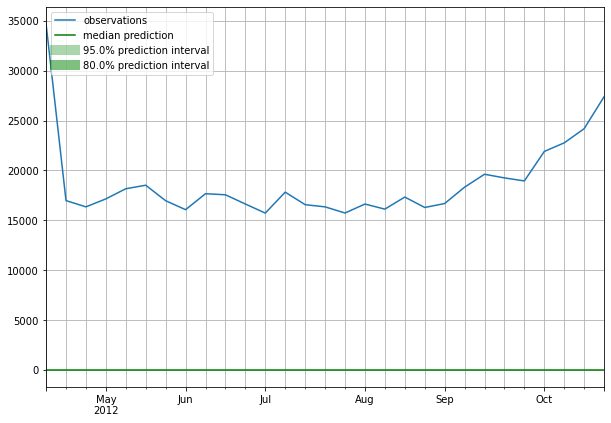

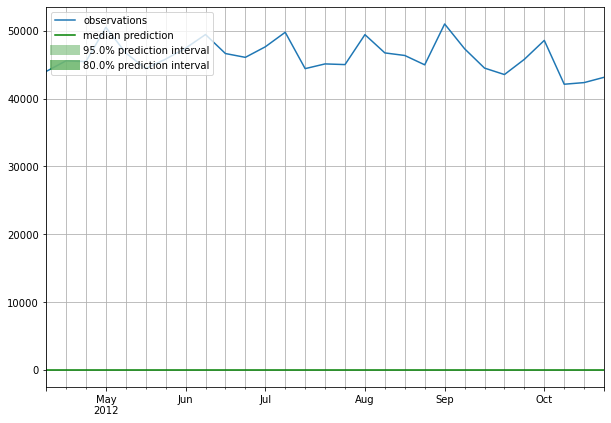

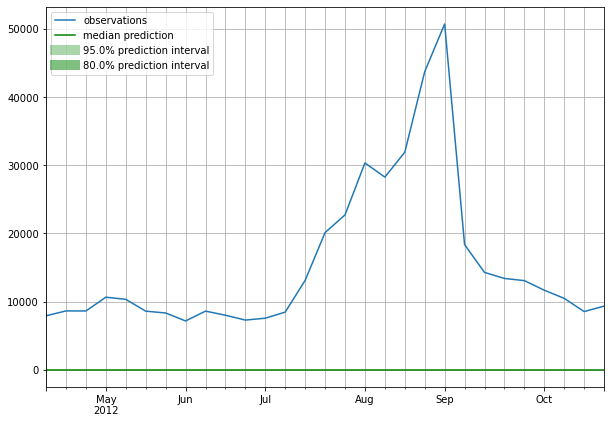

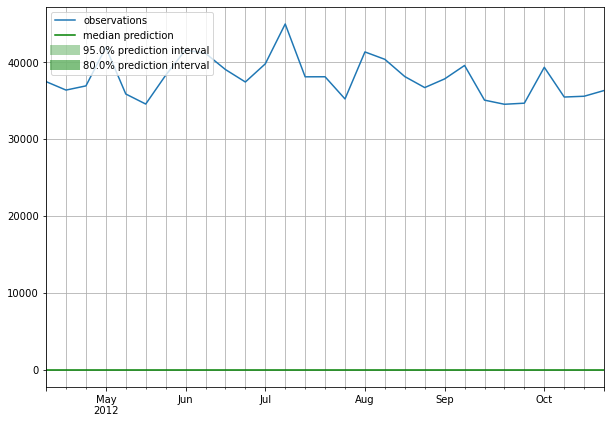

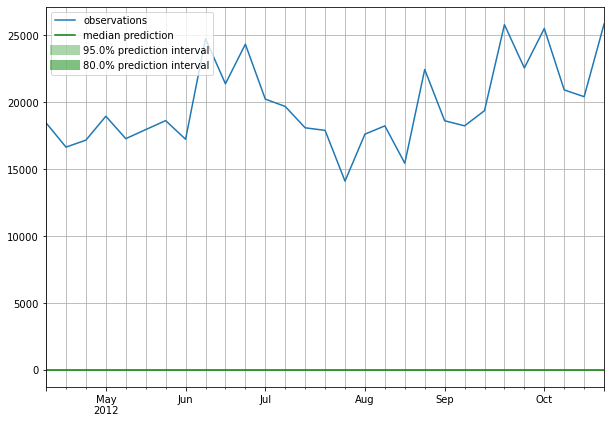

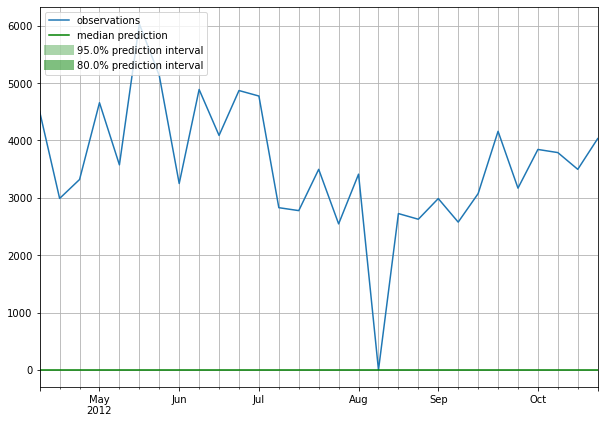

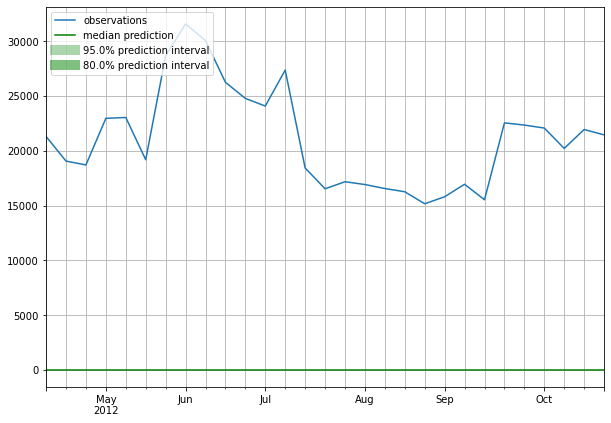

In [72]:
tss =  list(iter(ts_it))
forecasts = list(iter(forecast_it))

evaluator = Evaluator(quantiles=[0.1,0.5,0.9])
agg_metric,item_metric = evaluator(iter(tss),iter(forecasts),num_series=len(test_df))

for i in tqdm(range(7)):
    tss_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(tss_entry,forecast_entry)   

In [ ]:
forecasts[0]